##Installation and Setup##

In [70]:
%tensorflow_version 1.x
!pip show tensorflow
!pip install tf_slim

Name: tensorflow
Version: 1.15.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /tensorflow-1.15.2/python3.7
Requires: astor, opt-einsum, absl-py, protobuf, tensorflow-estimator, numpy, wrapt, six, wheel, google-pasta, keras-applications, termcolor, grpcio, gast, keras-preprocessing, tensorboard
Required-by: stable-baselines, magenta, fancyimpute


In [71]:
%cd /root/
!git clone https://github.com/tensorflow/models.git # Import required models from Github

/root
fatal: destination path 'models' already exists and is not an empty directory.


In [72]:
##install tensorboard
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip 
!unzip -o ngrok-stable-linux-amd64.zip

--2021-05-07 07:05:02--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.236.206.131, 52.203.96.188, 35.170.10.11, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.236.206.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.19M  13.5MB/s    in 1.0s    

2021-05-07 07:05:04 (13.5 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [73]:
#the logs that are created while training 
LOG_DIR = "/root/models/trained"
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
#The link to tensorboard.
#works after the training starts.
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


In [74]:
#setup env
%cd /root/models/research/
!protoc object_detection/protos/*.proto --python_out=.
import os
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/:/root/models/research/object_detection/utils/:/root/models/research/object_detection'
!python object_detection/builders/model_builder_test.py

/root/models/research


##Data Preprocessing

In [75]:
%cd /root/models/
!git clone https://github.com/fllay/totoro.git
os.getcwd()

/root/models
fatal: destination path 'totoro' already exists and is not an empty directory.


'/root/models'

In [76]:
##Convert xml to csv because tensorflow works in tfrecord data
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
	'''
    for directory in ['train','testing']:
        image_path = os.path.join(os.getcwd(), 'images/{}'.format(directory).format(directory))
        xml_df = xml_to_csv(image_path)
        xml_df.to_csv('data/{}_labels.csv'.format(directory), index=None)
        print('Successfully converted xml to csv.')
	''' 
	image_path = os.path.join(os.getcwd(), 'totoro/images/train')
	xml_df = xml_to_csv(image_path)
	xml_df.to_csv('totoro/data/train_labels.csv', index=None)

	image_path = os.path.join(os.getcwd(), 'totoro/images/test')
	xml_df = xml_to_csv(image_path)
	xml_df.to_csv('totoro/data/test_labels.csv',index=None)
main()

In [77]:
# ##Convert to tfRecords

%cd /root/models/research/
!protoc object_detection/protos/*.proto --python_out=.
#!export PYTHONPATH=$PYTHONPATH: /usr/local/lib/python3.6/dist-packages/tensorflow/models/research/:/usr/local/lib/python3.6/dist-packages/tensorflow/models/research/slim
#!pwd
#!python /usr/local/lib/python3.6/dist-packages/tensorflow/models/research/object_detection/builders/model_builder_test.py
#!python setup.py build
import os
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/:/root/models/research/object_detection/utils/:/root/models/research/object_detection'
%cd /root/models/totoro/tfrecord
!python generate_tfrecord.py --csv_input=/root/models/totoro/data/train_labels.csv  --output_path=train.record --image_dir=/root/models/totoro/images/train
!python generate_tfrecord.py --csv_input=/root/models/totoro/data/test_labels.csv  --output_path=test.record --image_dir=/root/models/totoro/images/test

/root/models/research
/root/models/totoro/tfrecord


W0507 07:05:13.494194 139906999891840 module_wrapper.py:139] From generate_tfrecord.py:90: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0507 07:05:13.577336 139906999891840 module_wrapper.py:139] From generate_tfrecord.py:49: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /root/models/totoro/tfrecord/train.record


W0507 07:05:17.232052 139909578835840 module_wrapper.py:139] From generate_tfrecord.py:90: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0507 07:05:17.237668 139909578835840 module_wrapper.py:139] From generate_tfrecord.py:49: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /root/models/totoro/tfrecord/test.record


In [78]:
##Download Pre-trained Models

%cd ~/models

import os
import shutil
import glob
import urllib
import tarfile
from requests import get

MODEL = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = 'pretrained_model'

if not (os.path.exists(MODEL_FILE)):
  with open(MODEL_FILE, "wb") as file:
    # get request
    response = get(DOWNLOAD_BASE + MODEL_FILE)
    # write to file
    file.write(response.content)
    #opener = urllib.URLopener()
    #opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/root/models


In [79]:
# Move Config file to directory "models"
shutil.move("/root/models/research/object_detection/samples/configs/ssd_mobilenet_v1_coco.config", "/root/models")

Error: ignored

In [80]:
##Modify the config file
%cd /root/models/research/
!protoc object_detection/protos/*.proto --python_out=.
#!export PYTHONPATH=$PYTHONPATH: /usr/local/lib/python3.6/dist-packages/tensorflow/models/research/:/usr/local/lib/python3.6/dist-packages/tensorflow/models/research/slim
#!pwd
#!python /usr/local/lib/python3.6/dist-packages/tensorflow/models/research/object_detection/builders/model_builder_test.py
#!python setup.py build
import os
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/:/root/models/research/object_detection/utils/:/root/models/research/object_detection'

# Edit Pipeline 
import tensorflow as tf
from google.protobuf import text_format
from object_detection.protos import pipeline_pb2

pipeline = pipeline_pb2.TrainEvalPipelineConfig()                                                                                                                                                                                                          
config_path = '/root/models/ssd_mobilenet_v1_coco.config'
with tf.gfile.GFile( config_path, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline)

pipeline.train_input_reader.tf_record_input_reader.input_path[:] = ['/root/models/totoro/tfrecord/train.record'] 
pipeline.train_input_reader.label_map_path = '/root/models/totoro/data/object-detection.pbtxt'
pipeline.eval_input_reader[0].tf_record_input_reader.input_path[:] = ['/root/models/totoro/tfrecord/test.record'] 
pipeline.eval_input_reader[0].label_map_path = '/root/models/totoro/data/object-detection.pbtxt'
pipeline.train_config.fine_tune_checkpoint = '/root/models/pretrained_model/model.ckpt'
pipeline.train_config.num_steps = 40
pipeline.model.ssd.num_classes = 2
pipeline.eval_config.num_examples = 5

config_text = text_format.MessageToString(pipeline)                                                                                                                                                                                                        
with tf.gfile.Open( config_path, "wb") as f:                                                                                                                                                                                                                       
    f.write(config_text)

/root/models/research


##Training##

In [81]:
# Change into the models directory
%cd /root/models/research/
!protoc object_detection/protos/*.proto --python_out=.
import os
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/:/root/models/research/object_detection/utils/:/root/models/research/object_detection'

# Begin training
!python /root/models/research/object_detection/legacy/train.py \
    --logtostderr \
    --train_dir=/root/models/trained \
    --pipeline_config_path=/root/models/ssd_mobilenet_v1_coco.config

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0507 07:05:57.901657 139867756791680 deprecation.py:506] From /tensorflow-1.15.2/python3.7/tensorflow_core/python/training/rmsprop.py:119: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0507 07:05:59.241267 139867756791680 deprecation.py:323] From /tensorflow-1.15.2/python3.7/tensorflow_core/python/training/moving_averages.py:433: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initi

In [82]:
##Identify the latest trained model
##Export Model
lst = os.listdir('/root/models/trained')
lf = filter(lambda k: 'model.ckpt-' in k, lst)
last_model = sorted(lf)[-1].replace('.meta', '')
os.environ['last_model']=last_model

# Export trained model
!python /root/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/root/models/ssd_mobilenet_v1_coco.config \
    --output_directory=/root/models/fine_tuned_model \
    --trained_checkpoint_prefix=/root/models/trained/$last_model

Instructions for updating:
Please use `layer.__call__` method instead.
W0507 07:06:06.782660 140416341489536 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0507 07:06:08.393728 140416341489536 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0507 07:06:08.433932 140416341489536 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0507 07:06:08.471534 140416341489536 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv befo

##Classify##

In [83]:
# This is needed to display the images.

import pathlib
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
%matplotlib inline

In [84]:
# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/root/models/fine_tuned_model' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/root/models/totoro/data/object-detection.pbtxt'

NUM_CLASSES = 2

In [85]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [86]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [87]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)
# For the sake of simplicity we will use only 5 images:
# from image1.jpg
# to image5.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/root/models/totoro/images/test'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 7) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [88]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

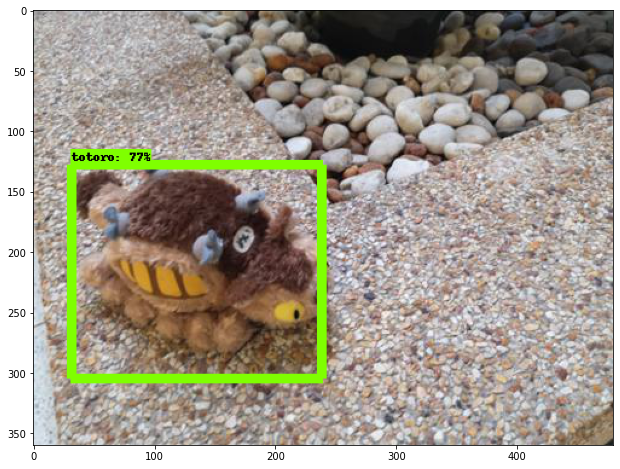

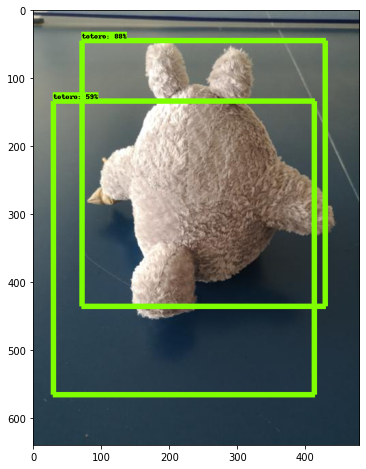

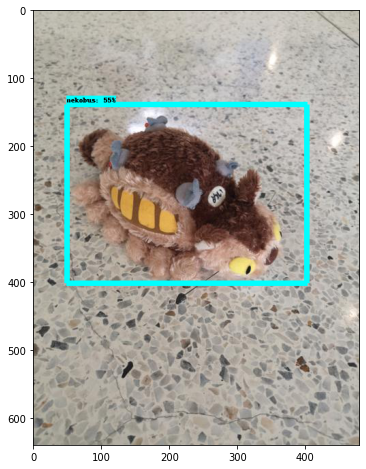

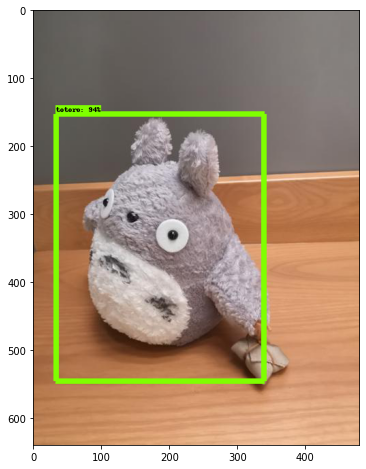

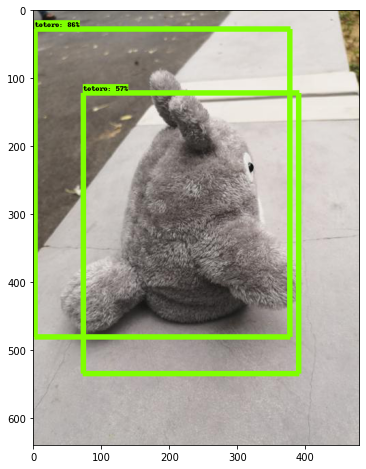

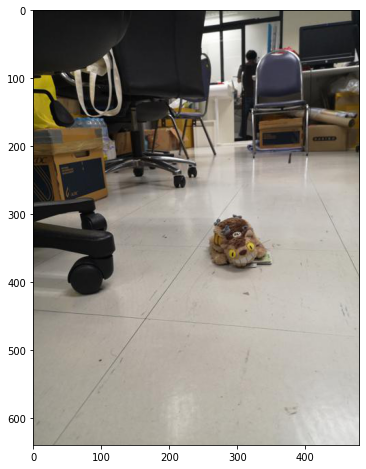

In [89]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)